# Introduction/Business Problem

Imagine there is a **travel provider**, who has a special offer in his portfolio: You can book a trip to New York and attend a home game of the New York Yankees. So, the customers can enjoy a Yankee match and in the rest of the time (usually a few days) they are free to explore New York City. <br>
The travel provider has access to various lodgings in different neighborhoods. It is important that the Yankees stadium is easy to reach from the lodging with regard to the high traffic volume before Yankees matches. From his experience, he knows that the boroughs Manhattan and Bronx are optimal in this particular case. <br>
Now, the provider doesn't want to just randomly pick neighborhoods in Manhattan or Bronx in order to prevent customer dissatisfaction. At the same time he doesn't want to present customers a long list of neighborhoods, making them choose without any information about the neighborhoods. <br>
The provider has an idea: He hires a data scientist and gives him the task to cluster the neighborhoods in Manhattan and Bronx with regard to similar venues in a specific radius of each neighborhood. In this way, he can **propose a specific set of neighborhoods to his customers based on their personal preferences**. As soon as the customer chooses a cluster, the provider can check which lodgings are available in the neighborhoods of that cluster. The audience of this project is cleary the travel provider, who wants to improve customer experience with the help of data science.

# Data

For this project, the json-file *nyu_2451_34572-geojson.json* is used which can be downloaded via https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json . It comprises all boroughs and neighborhoods in New York togehter with their geometric coordinates. The relevant information are stored in a dataframe and all neighborhoods that are not located in Bronx or Manhattan are removed. <br>
The dataframe looks as follows: 
![](https://i.imgur.com/TwGA7ey.png)
<br>
Additionally, Foursquare location data is used to obtain information about the venues in the vicinity of each neighborhood. A request URL looks for example like this:
https://api.foursquare.com/v2/venues/explore?&client_id=xxx&client_secret=xxx&v=20180605&ll=40.894705,-73.847201&radius=500&limit=100
and provides information like this:
![](https://i.imgur.com/l0dekNx.png)
We will be interested in the information that is stored under 'categories' 'name', in this case *Dessert Shop*.
<br>
<br>
A function is defined that retrieves the top 100 venues within a radius of 500m for the location of each neighborhood. The data is stored in a dataframe that looks like this:
![](https://i.imgur.com/i8xqxCt.png)
<br>
The dataframe is then manipulated in a way that for each neighborhood, the frequency of occurence of each venue category is provided:
![](https://i.imgur.com/Ds4W0JU.png)
<br>
Based on this, a dataframe is created where each neighborhood is listed among with its 10 most common venues within 500m:
![](https://i.imgur.com/EMT5dnK.png)
<br>
*Note: The exact procedure of creating the above dataframes will be provided in the following sections.*

# Data exploration

### Import required libraries

In [1]:
import requests
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import itertools # iterate colors for different clusters on map

from scipy.spatial.distance import cdist # distance metric for elbow method

from collections import Counter # count words in a list 

print('Libraries imported.')

Libraries imported.


### Load data of New York's neighborhoods

In [2]:
with open('nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
neighborhoods_data = newyork_data['features']

### Create DataFrame

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [5]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Get location information and visualize them with maps

#### Use geopy library to get the latitude and longitude values of New York City

In [8]:
address = 'New York City, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

C:\Users\dvq6zm\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of New York City are 40.7308619, -73.9871558.


#### Get the latitude and longitude values of the Yankee Stadium

In [9]:
yankee_address = 'Yankee Stadium, NY'

geolocator = Nominatim()
location = geolocator.geocode(yankee_address)
yankee_latitude = location.latitude
yankee_longitude = location.longitude
print('The geograpical coordinate of the Yankee Stadium are {}, {}.'.format(yankee_latitude, yankee_longitude))

C:\Users\dvq6zm\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of the Yankee Stadium are 40.82958275, -73.926521184919.


#### Create a map of New York with neighborhoods superimposed on top. The Yankee Stadium is added with a larger black circle

In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers for neighborhoods to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork)  

# add marker for Yankee Stadium to map
folium.CircleMarker([yankee_latitude,yankee_longitude],
                    radius=10,
                    popup='Yankee Stadium',
                    color='black',
                    fill=True,
                    fill_color='##0e0304',
                    fill_opacity=0.7).add_to(map_newyork)

map_newyork

#### Now let's concentrate on Bronx and Manhattan. Create a new dataframe that only contains neighborhoods from those two boroughs

In [11]:
bronx_manhattan_data = neighborhoods[(neighborhoods['Borough']=='Bronx') | (neighborhoods['Borough']=='Manhattan')].reset_index(drop=True)
print(bronx_manhattan_data.shape)
bronx_manhattan_data.head()

(92, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


-> There are in total 92 neighborhoods in Bronx and Manhattan

#### Create a map around the Yankee Stadium and add markers for the neighborhoods in Manhattan and Bronx

In [12]:
# create map of Brooklyn using latitude and longitude values
map_yankee = folium.Map(location=[yankee_latitude, yankee_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(bronx_manhattan_data['Latitude'], bronx_manhattan_data['Longitude'], bronx_manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_yankee)  

folium.CircleMarker([yankee_latitude,yankee_longitude],
                    radius=10,
                    popup='Yankee Stadium',
                    color='black',
                    fill=True,
                    fill_color='black',
                    fill_opacity=0.7).add_to(map_yankee)

map_yankee

### Set up the Foursquare API and get the venue data for our neighborhoods

#### Define Foursquare Credentials and Version

In [13]:
CLIENT_ID = 'xxx' #hidden afterwards
CLIENT_SECRET = 'xxx' #hidden afterwards
VERSION = '20180605'

#### From the Foursquare lab, we know that all the information is in the _items_ key. Before we proceed, let's borrow the *get_category_type* function from the Foursquare lab.

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Let's create a function to get the top 100 venues within a radius of 500 meters for each neighborhood

In [15]:
radius = 500
LIMIT = 100

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each neighborhood and create a new dataframe called *bronx_manhattan_venues*

In [17]:
bronx_manhattan_venues = getNearbyVenues(names=bronx_manhattan_data['Neighborhood'],
                                         latitudes=bronx_manhattan_data['Latitude'],
                                         longitudes=bronx_manhattan_data['Longitude'],
                                         radius=500)

#### Let's check the shape and head of the resulting dataframe

In [18]:
print(bronx_manhattan_venues.shape)
bronx_manhattan_venues.head()

(4523, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896521,-73.844680,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Dunkin Donuts,40.890631,-73.849027,Donut Shop
4,Wakefield,40.894705,-73.847201,SUBWAY,40.890656,-73.849192,Sandwich Place


#### Let's find out how many unique categories can be curated from all the returned venues


In [19]:
print('There are {} unique categories.'.format(len(bronx_manhattan_venues['Venue Category'].unique())))

There are 356 unique categories.


#### Let's check how many venues were returned for each neighborhood

In [20]:
bronx_manhattan_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,29,29,29,29,29,29
Battery Park City,100,100,100,100,100,100
Baychester,20,20,20,20,20,20
Bedford Park,36,36,36,36,36,36
Belmont,95,95,95,95,95,95


### Analyze Each Neighborhood

#### Create a new dataframe where each venue category is represented by a column and each neighborhood by a row. <br> A value of 1 indicates that a venue category occurs in the respective neighborhood

In [21]:
# one hot encoding
bronx_manhattan_onehot = pd.get_dummies(bronx_manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bronx_manhattan_onehot['Neighborhood'] = bronx_manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bronx_manhattan_onehot.columns[-1]] + list(bronx_manhattan_onehot.columns[:-1])
bronx_manhattan_onehot = bronx_manhattan_onehot[fixed_columns]

print(bronx_manhattan_onehot.shape)
bronx_manhattan_onehot.head()

(4523, 357)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon /

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [22]:
bronx_manhattan_grouped = bronx_manhattan_onehot.groupby('Neighborhood').mean().reset_index()
print(bronx_manhattan_grouped.shape)
bronx_manhattan_grouped.head()

(92, 357)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon /

### Let's create a dataframe where each neighborhood is listet along with the top 10 most common venues

#### First, let's write a function to sort the venues in descending order

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Create the dataframe

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bronx_manhattan_grouped['Neighborhood']

for ind in np.arange(bronx_manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bronx_manhattan_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(92, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Supermarket,Deli / Bodega,Chinese Restaurant,Spa,Department Store,Pharmacy,Breakfast Spot,Bus Station,Spanish Restaurant
1,Battery Park City,Coffee Shop,Park,Hotel,Italian Restaurant,Wine Shop,Gym,Women's Store,Memorial Site,Shopping Mall,Sandwich Place
2,Baychester,American Restaurant,Supermarket,Pet Store,Spanish Restaurant,Mexican Restaurant,Fast Food Restaurant,Men's Store,Mattress Store,Electronics Store,Baseball Field
3,Bedford Park,Diner,Fried Chicken Joint,Deli / Bodega,Mexican Restaurant,Chinese Restaurant,Supermarket,Pizza Place,Sandwich Place,Pharmacy,Train Station
4,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Grocery Store,Dessert Shop,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Sandwich Place


# Machine Learning

### Cluster Neighborhoods

#### Run *k*-means to cluster the neighborhood into 3 clusters

In [52]:
# set number of clusters
kclusters = 3

bronx_manhattan_grouped_clustering = bronx_manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init=100,random_state=0, algorithm='auto').fit(bronx_manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 1, 1, 2, 2, 2, 1, 2, 2])

### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [53]:
bronx_manhattan_merged = bronx_manhattan_data.copy()

# add clustering labels
bronx_manhattan_merged['Cluster'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bronx_manhattan_merged = bronx_manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

print(bronx_manhattan_merged.shape)
bronx_manhattan_merged[bronx_manhattan_merged.columns[[0,1,4,5,6,7,8,9,10,11,12,13,14]]].head()

(92, 15)


,Borough,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,1,Food Truck,Ice Cream Shop,Food,Pharmacy,Dessert Shop,Donut Shop,Sandwich Place,Laundromat,Yoga Studio,Fast Food Restaurant
1,Bronx,Co-op City,2,Bus Station,Baseball Field,Accessories Store,Discount Store,Fried Chicken Joint,Chinese Restaurant,Mattress Store,Grocery Store,Basketball Court,Bar
2,Bronx,Eastchester,1,Caribbean Restaurant,Deli / Bodega,Diner,Bus Station,Convenience Store,Fast Food Restaurant,Chinese Restaurant,Donut Shop,Metro Station,Bowling Alley
3,Bronx,Fieldston,1,Plaza,Playground,River,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market
4,Bronx,Riverdale,2,Park,Bank,Food Truck,Bus Station,Plaza,Home Service,Fish & Chips Shop,Event Space,Exhibit,Eye Doctor


### Visualize the resulting clusters

In [54]:
# create map
map_clusters = folium.Map(location=[yankee_latitude, yankee_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+2))
temp = [colors.rgb2hex(i) for i in colors_array]
rainbow = []
rainbow.append(temp[0])
rainbow.append(temp[1])
rainbow.append(temp[4])

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bronx_manhattan_merged['Latitude'], bronx_manhattan_merged['Longitude'], bronx_manhattan_merged['Neighborhood'], bronx_manhattan_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analyze the clusters

#### Show the top 10 venues the first five neighborhoods in cluster 0

In [55]:
bronx_manhattan_merged[bronx_manhattan_merged['Cluster']==0][bronx_manhattan_merged.columns[[0,1,4,5,6,7,8,9,10,11,12,13,14]]].head()

,Borough,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Bronx,University Heights,0,Pizza Place,Shoe Store,Fast Food Restaurant,Cosmetics Shop,Latin American Restaurant,Donut Shop,Sandwich Place,Clothing Store,Chinese Restaurant,Spanish Restaurant
67,Manhattan,Little Italy,0,Bakery,Café,Yoga Studio,Cocktail Bar,Sandwich Place,Salon / Barbershop,Ice Cream Shop,Seafood Restaurant,Chinese Restaurant,Bubble Tea Shop
72,Manhattan,Gramercy,0,Italian Restaurant,Cocktail Bar,Wine Shop,Thrift / Vintage Store,Bagel Shop,Restaurant,Grocery Store,Mexican Restaurant,Pizza Place,Coffee Shop


#### Check the sizes of each cluster

In [56]:
for i in range(0,kclusters):
    print('Cluster ' + str(i))
    print(bronx_manhattan_merged[bronx_manhattan_merged['Cluster']==i].shape)
    print()

Cluster 0
(3, 15)

Cluster 1
(39, 15)

Cluster 2
(50, 15)



-> Cluster 0 includes 3 neighborhoods, cluster 1 includes 39 neighborhoods and cluster 2 includes 50 neighborhoods

#### For each cluster, check the most frequent venues and their relative occurence inside the respective cluster

In [43]:
for i in range(0,kclusters):
    print('Cluster '+ str(i))
    a = Counter(bronx_manhattan_merged[bronx_manhattan_merged['Cluster']==i][bronx_manhattan_merged.columns[[5,6,7,8,9,10,11,12,13,14]]].values.flatten()).most_common(5)
    total = len(bronx_manhattan_merged[bronx_manhattan_merged['Cluster']==i][bronx_manhattan_merged.columns[[5,6,7,8,9,10,11,12,13,14]]].values.flatten())
    num = 1
    for each in a:
        print(str(num) + ': ' + each[0] + '  ' + str(round(each[1]/total*100,1)) + '%')
        num = num+1
    print()

Cluster 0
1: Pizza Place  6.7%
2: Sandwich Place  6.7%
3: Chinese Restaurant  6.7%
4: Cocktail Bar  6.7%
5: Shoe Store  3.3%

Cluster 1
1: Deli / Bodega  4.6%
2: Pizza Place  4.4%
3: Sandwich Place  3.6%
4: Italian Restaurant  3.6%
5: Coffee Shop  3.3%

Cluster 2
1: Pizza Place  4.8%
2: Italian Restaurant  4.2%
3: Coffee Shop  4.0%
4: Park  3.0%
5: Grocery Store  2.8%



### Try other *k*-values

#### Setting *k*=3 seemed a bit arbitrary. Let's try to find a good *k*-value with the elbow method

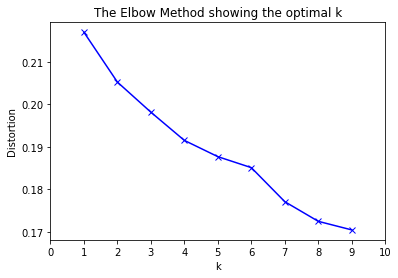

In [58]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeans_elbow = KMeans(n_clusters=k,n_init=100,random_state=0,algorithm='auto').fit(bronx_manhattan_grouped_clustering)
    #kmeans.fit(scaled_manhatten_df)
    distortions.append(sum(np.min(cdist(bronx_manhattan_grouped_clustering, kmeans_elbow.cluster_centers_, 'euclidean'), axis=1)) / bronx_manhattan_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.xticks(np.arange(0, 11, step=1))
plt.show()

-> Unfortunately, the curve doesn't show an elbow shape. Hence, it is not possible to determine an optimal *k* value in this way. However, it turns out that choosing *k*>3 results in at least one cluster that has only one neighborhood. To show this, we run the algorithm for *k*=4 in the following cell:

In [41]:
# set number of clusters
kclusters4 = 4

bronx_manhattan_grouped_clustering4 = bronx_manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans4 = KMeans(n_clusters=kclusters4, n_init=100,random_state=0).fit(bronx_manhattan_grouped_clustering)


#create dataframe
bronx_manhattan_merged4 = bronx_manhattan_data.copy()

# add clustering labels
bronx_manhattan_merged4['Cluster'] = kmeans4.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bronx_manhattan_merged4 = bronx_manhattan_merged4.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


# create map
map_clusters4 = folium.Map(location=[yankee_latitude, yankee_longitude], zoom_start=11)

# set color scheme for the clusters
#mycolors4 = itertools.cycle(["blue", "red", "green","yellow"])
x = np.arange(kclusters4)
ys = [i+x+(i*x)**2 for i in range(kclusters4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+1))
temp = [colors.rgb2hex(i) for i in colors_array]
rainbow = []
rainbow.append(temp[0])
rainbow.append(temp[1])
rainbow.append(temp[3])
rainbow.append(temp[4])

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bronx_manhattan_merged4['Latitude'], bronx_manhattan_merged4['Longitude'], bronx_manhattan_merged4['Neighborhood'], bronx_manhattan_merged4['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #thiscolor = next(mycolors4) # iterate through the defined colors
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters4)
       
map_clusters4

In [42]:
for i in range(0,kclusters4):
    print('Cluster ' + str(i))
    print(bronx_manhattan_merged4[bronx_manhattan_merged4['Cluster']==i].shape)
    print()

Cluster 0
(45, 15)

Cluster 1
(1, 15)

Cluster 2
(43, 15)

Cluster 3
(3, 15)



-> Cluster 1 has only one neighborhood. The same effect occurs for larger values of *k*. Since clusters with a single neighborhood are not very useful for our business problem, *k*=3 is an appropriate choice.